In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive/My Drive

/content/drive/My Drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
from tensorflow.keras import backend as K
class mish(Activation):
    def __init__(self, activation, **kwargs):
        super(mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def Mish(x):
    return x*K.tanh(K.softplus(x))

get_custom_objects().update({'mish': mish(Mish)}) 

In [5]:
train_img = train.iloc[:,3:].to_numpy().reshape(-1,28,28,1)
train_digit = train['digit']
train_letter = train['letter']
test_img = test.iloc[:,2:].to_numpy().reshape(-1,28,28,1)
test_letter = test['letter']

train_img_norm = train_img / 255.0
test_img_norm = test_img / 255.0

features = train_img_norm
labels = train_digit.to_numpy()

X_test = test_img_norm

from sklearn.model_selection import train_test_split

validation_split = 0.2

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size = validation_split, random_state = 100)

In [6]:
def createFolder(directory):
    
    import os
    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except:
        print("Error: Falied creating directory" + directory)

def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                ax[i].plot(epochs, y)
                ax[i].set_title('Loss')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    ax[i].plot(epochs, y)
                    ax[i].set_title('Accuracy')
                    
    plt.show()

In [15]:
def create_cnn(learning_rate):
    
    # Remove the previous model.
    model = None
    
    # Input layer
    img_input = layers.Input(shape = (28,28,1))
    
    # CNN
    # Identity mapping shortcut을 위한 conv_1 layer
    conv_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')(img_input) 
    
    conv_2_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')(conv_1)
    conv_2_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_1)
    
    # ShortCut connection
    add_2_1 = layers.add([conv_1, conv_2_1])
    out_2_1 = layers.Activation('relu')(add_2_1)
    
    conv_2_2 = layers.Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')(out_2_1)
    conv_2_2 = layers.Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_2)
    
    # ShortCut connection
    add_2_2 = layers.add([out_2_1, conv_2_2])
    out_2_2 = layers.Activation('relu')(add_2_1)
    
    pool_2 = layers.MaxPool2D((2,2), strides = 2)(out_2_2)
    
    conv_3_0 = layers.Conv2D(256, kernel_size = 1, strides = 1)(pool_2)
    
    conv_3_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu')(conv_3_0)
    conv_3_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_1)
    
    # ShortCut connection
    add_3_1 = layers.add([conv_3_0, conv_3_1])
    out_3_1 = layers.Activation('relu')(add_3_1)
    
    conv_3_2 = layers.Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu')(out_3_1)
    conv_3_2 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_2)
    
    # ShortCut connection
    add_3_2 = layers.add([out_3_1, conv_3_2])
    out_3_2 = layers.Activation('relu')(add_3_2)
    
    pool_3 = layers.MaxPool2D((2,2), strides = 2)(out_3_2)
    
    conv_4_0 = layers.Conv2D(256, kernel_size = 1, strides = 1)(pool_3)
    
    conv_4_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu')(conv_4_0)
    conv_4_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_4_1)
    
    # ShortCut connection
    add_4_1 = layers.add([conv_4_0, conv_4_1])
    out_4_1 = layers.Activation('relu')(add_4_1)
    
    pool_4 = layers.MaxPool2D((2,2), strides = 2)(out_4_1)
    
    # FC layers
    img_features = layers.Flatten()(pool_4)
    img_features = layers.Dense(512, activation = 'relu')(img_features)
    img_features = layers.Dropout(rate = 0.5)(img_features)
    img_features = layers.Dense(512, activation = 'relu')(img_features)
    img_features = layers.Dropout(rate = 0.5)(img_features)
    
    # Output layer
    digit_pred = layers.Dense(10, activation = 'softmax')(img_features)
    
    model = tf.keras.Model(inputs = img_input, outputs = digit_pred)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = learning_rate),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
                    
    return model


def train_model_v1(model, X_train, y_train, epochs, batch_size = None, validation_split = 0.1):
    
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)
    
    history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_split = validation_split, callbacks = [callback])
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

def train_model_v2(model, X_train, y_train,  epochs, batch_size = None, validation_split = 0.1):
    
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
    
    history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_split = validation_split, callbacks = [callback])
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

In [16]:
model_list = []

for i in range(10):
    model = create_cnn(learning_rate = 0.0001)
    model_list.append(model)

***************Trainig_my_model_0*****************
Epoch 1/200
1843/1843 [==============================] - 9s 5ms/step - loss: 2.3064 - accuracy: 0.0977 - val_loss: 2.3023 - val_accuracy: 0.0829
Epoch 2/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.1990 - accuracy: 0.1758 - val_loss: 1.7679 - val_accuracy: 0.3805
Epoch 3/200
1843/1843 [==============================] - 8s 4ms/step - loss: 1.4131 - accuracy: 0.5187 - val_loss: 0.9650 - val_accuracy: 0.6780
Epoch 4/200
1843/1843 [==============================] - 8s 4ms/step - loss: 0.8556 - accuracy: 0.7238 - val_loss: 0.5734 - val_accuracy: 0.8098
Epoch 5/200
1843/1843 [==============================] - 8s 4ms/step - loss: 0.6012 - accuracy: 0.8020 - val_loss: 0.5775 - val_accuracy: 0.8000
Epoch 6/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.4533 - accuracy: 0.8568 - val_loss: 0.4589 - val_accuracy: 0.8585
Epoch 7/200
1843/1843 [==============================] - 8s 4ms/step - loss: 0.

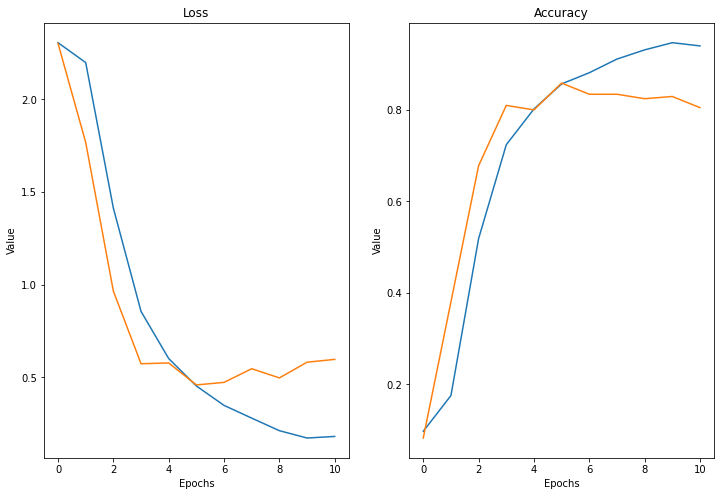

***************Trainig_my_model_1*****************
Epoch 1/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.3051 - accuracy: 0.1156 - val_loss: 2.2775 - val_accuracy: 0.1122
Epoch 2/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.1789 - accuracy: 0.1970 - val_loss: 1.6470 - val_accuracy: 0.3902
Epoch 3/200
1843/1843 [==============================] - 8s 4ms/step - loss: 1.3358 - accuracy: 0.5524 - val_loss: 0.7883 - val_accuracy: 0.7268
Epoch 4/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.7893 - accuracy: 0.7406 - val_loss: 0.5259 - val_accuracy: 0.8341
Epoch 5/200
1843/1843 [==============================] - 8s 4ms/step - loss: 0.5847 - accuracy: 0.8058 - val_loss: 0.5067 - val_accuracy: 0.8341
Epoch 6/200
1843/1843 [==============================] - 8s 4ms/step - loss: 0.4309 - accuracy: 0.8568 - val_loss: 0.4278 - val_accuracy: 0.8341
Epoch 7/200
1843/1843 [==============================] - 8s 4ms/step - loss: 0.

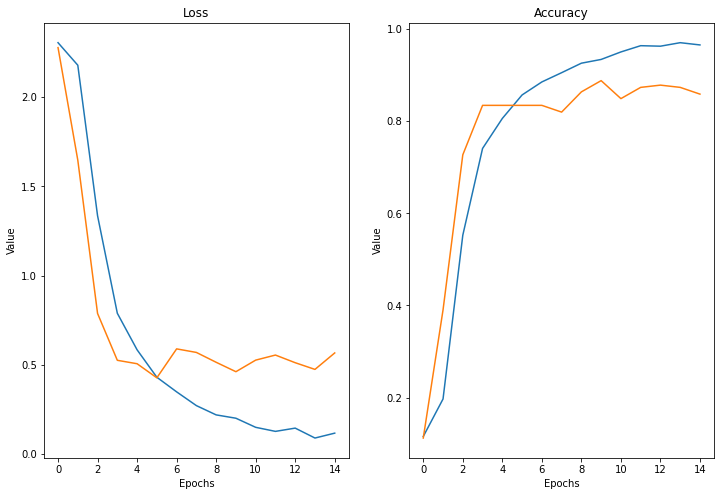

***************Trainig_my_model_2*****************
Epoch 1/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.3070 - accuracy: 0.1063 - val_loss: 2.3037 - val_accuracy: 0.0976
Epoch 2/200
1843/1843 [==============================] - 7s 4ms/step - loss: 2.1455 - accuracy: 0.2165 - val_loss: 1.6619 - val_accuracy: 0.4341
Epoch 3/200
1843/1843 [==============================] - 7s 4ms/step - loss: 1.3802 - accuracy: 0.5393 - val_loss: 0.8281 - val_accuracy: 0.7317
Epoch 4/200
1843/1843 [==============================] - 8s 4ms/step - loss: 0.8320 - accuracy: 0.7325 - val_loss: 0.6244 - val_accuracy: 0.7854
Epoch 5/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.5742 - accuracy: 0.8231 - val_loss: 0.6100 - val_accuracy: 0.8000
Epoch 6/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.4406 - accuracy: 0.8568 - val_loss: 0.4391 - val_accuracy: 0.8683
Epoch 7/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.

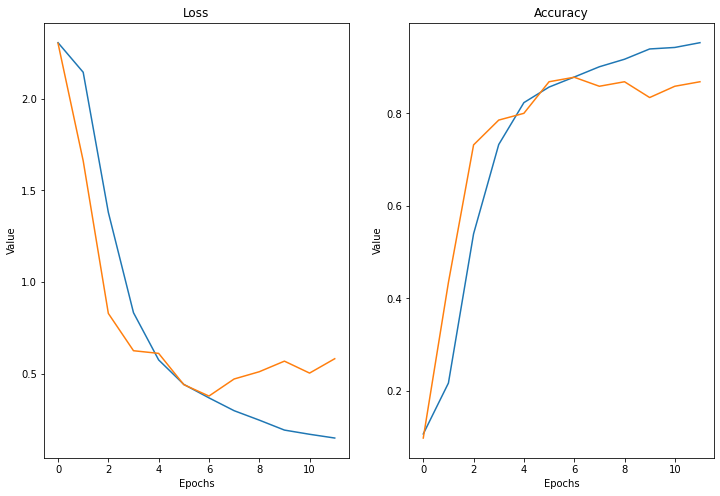

***************Trainig_my_model_3*****************
Epoch 1/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.3057 - accuracy: 0.1091 - val_loss: 2.2961 - val_accuracy: 0.0829
Epoch 2/200
1843/1843 [==============================] - 7s 4ms/step - loss: 2.1573 - accuracy: 0.2008 - val_loss: 1.7370 - val_accuracy: 0.3707
Epoch 3/200
1843/1843 [==============================] - 8s 4ms/step - loss: 1.4056 - accuracy: 0.5279 - val_loss: 0.9346 - val_accuracy: 0.6780
Epoch 4/200
1843/1843 [==============================] - 8s 4ms/step - loss: 0.8326 - accuracy: 0.7325 - val_loss: 0.6187 - val_accuracy: 0.8049
Epoch 5/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.6029 - accuracy: 0.7998 - val_loss: 0.6812 - val_accuracy: 0.7805
Epoch 6/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.4713 - accuracy: 0.8578 - val_loss: 0.5122 - val_accuracy: 0.8244
Epoch 7/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.

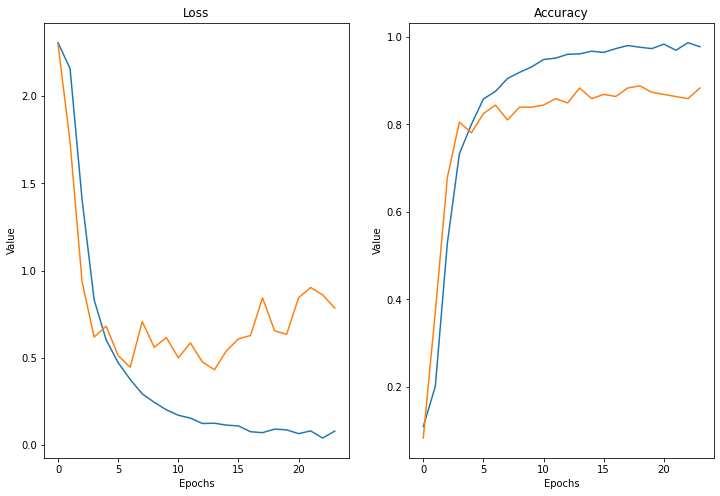

***************Trainig_my_model_4*****************
Epoch 1/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.3063 - accuracy: 0.1031 - val_loss: 2.3118 - val_accuracy: 0.0829
Epoch 2/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.2971 - accuracy: 0.1123 - val_loss: 2.3043 - val_accuracy: 0.0927
Epoch 3/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.2352 - accuracy: 0.1595 - val_loss: 1.9837 - val_accuracy: 0.2683
Epoch 4/200
1843/1843 [==============================] - 8s 4ms/step - loss: 1.6335 - accuracy: 0.4368 - val_loss: 1.2077 - val_accuracy: 0.5659
Epoch 5/200
1843/1843 [==============================] - 8s 4ms/step - loss: 0.9366 - accuracy: 0.6880 - val_loss: 0.6963 - val_accuracy: 0.7902
Epoch 6/200
1843/1843 [==============================] - 8s 4ms/step - loss: 0.6549 - accuracy: 0.7846 - val_loss: 0.5069 - val_accuracy: 0.8390
Epoch 7/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.

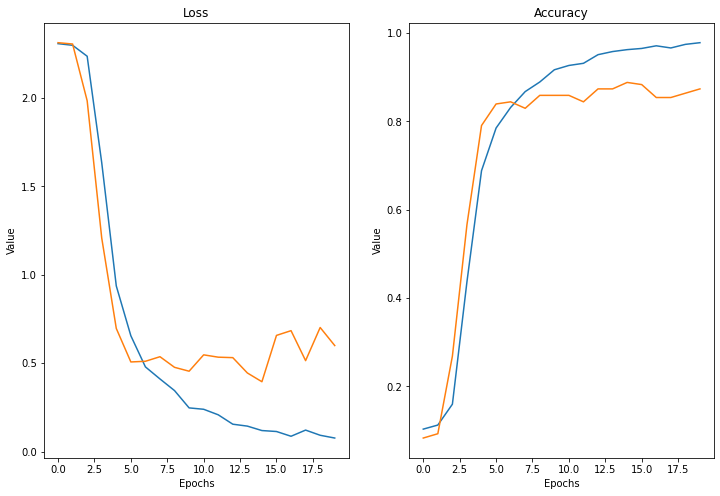

***************Trainig_my_model_5*****************
Epoch 1/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.3074 - accuracy: 0.1020 - val_loss: 2.3014 - val_accuracy: 0.1366
Epoch 2/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.1322 - accuracy: 0.2138 - val_loss: 1.5693 - val_accuracy: 0.3902
Epoch 3/200
1843/1843 [==============================] - 8s 4ms/step - loss: 1.2909 - accuracy: 0.5583 - val_loss: 0.8992 - val_accuracy: 0.7415
Epoch 4/200
1843/1843 [==============================] - 8s 4ms/step - loss: 0.8302 - accuracy: 0.7320 - val_loss: 0.6616 - val_accuracy: 0.7756
Epoch 5/200
1843/1843 [==============================] - 8s 4ms/step - loss: 0.5858 - accuracy: 0.8074 - val_loss: 0.5600 - val_accuracy: 0.8341
Epoch 6/200
1843/1843 [==============================] - 8s 4ms/step - loss: 0.4595 - accuracy: 0.8557 - val_loss: 0.4312 - val_accuracy: 0.8439
Epoch 7/200
1843/1843 [==============================] - 8s 4ms/step - loss: 0.

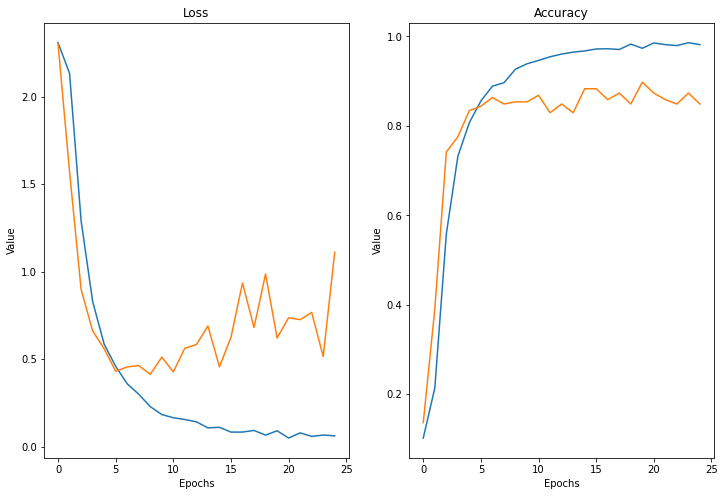

***************Trainig_my_model_6*****************
Epoch 1/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.3039 - accuracy: 0.1080 - val_loss: 2.2835 - val_accuracy: 0.0829
Epoch 2/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.0015 - accuracy: 0.2935 - val_loss: 1.2527 - val_accuracy: 0.5902
Epoch 3/200
1843/1843 [==============================] - 7s 4ms/step - loss: 1.1836 - accuracy: 0.6099 - val_loss: 0.8204 - val_accuracy: 0.7024
Epoch 4/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.7757 - accuracy: 0.7488 - val_loss: 0.6643 - val_accuracy: 0.7366
Epoch 5/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.5675 - accuracy: 0.8204 - val_loss: 0.5846 - val_accuracy: 0.8195
Epoch 6/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.4561 - accuracy: 0.8551 - val_loss: 0.5824 - val_accuracy: 0.8390
Epoch 7/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.

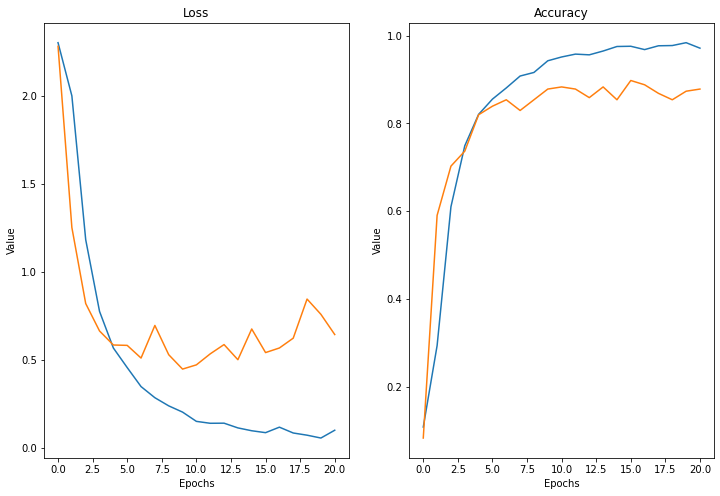

***************Trainig_my_model_7*****************
Epoch 1/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.3060 - accuracy: 0.1172 - val_loss: 2.3018 - val_accuracy: 0.0878
Epoch 2/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.1406 - accuracy: 0.1997 - val_loss: 1.9004 - val_accuracy: 0.3122
Epoch 3/200
1843/1843 [==============================] - 7s 4ms/step - loss: 1.3909 - accuracy: 0.5203 - val_loss: 0.8829 - val_accuracy: 0.6878
Epoch 4/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.8307 - accuracy: 0.7330 - val_loss: 0.6396 - val_accuracy: 0.7805
Epoch 5/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.6088 - accuracy: 0.8085 - val_loss: 0.5451 - val_accuracy: 0.7854
Epoch 6/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.4837 - accuracy: 0.8367 - val_loss: 0.5116 - val_accuracy: 0.8293
Epoch 7/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.

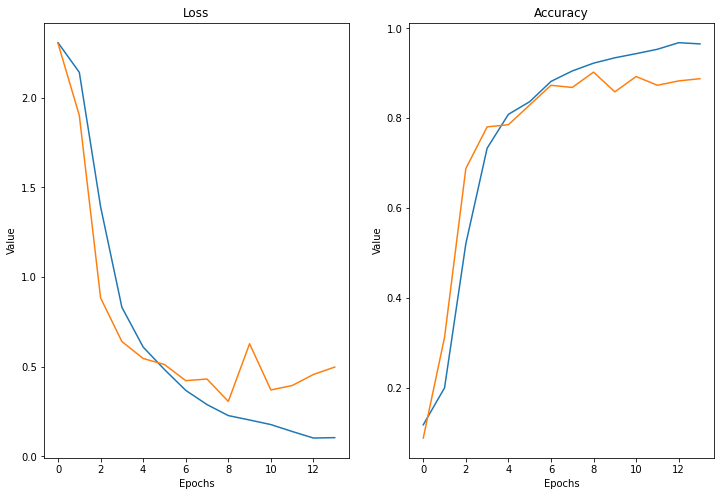

***************Trainig_my_model_8*****************
Epoch 1/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.3058 - accuracy: 0.1150 - val_loss: 2.2992 - val_accuracy: 0.0829
Epoch 2/200
1843/1843 [==============================] - 7s 4ms/step - loss: 2.1322 - accuracy: 0.2198 - val_loss: 1.6576 - val_accuracy: 0.4098
Epoch 3/200
1843/1843 [==============================] - 7s 4ms/step - loss: 1.3377 - accuracy: 0.5529 - val_loss: 0.8304 - val_accuracy: 0.6927
Epoch 4/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.8053 - accuracy: 0.7401 - val_loss: 0.6281 - val_accuracy: 0.8098
Epoch 5/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.5977 - accuracy: 0.8128 - val_loss: 0.5223 - val_accuracy: 0.8293
Epoch 6/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.4680 - accuracy: 0.8475 - val_loss: 0.4389 - val_accuracy: 0.8732
Epoch 7/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.

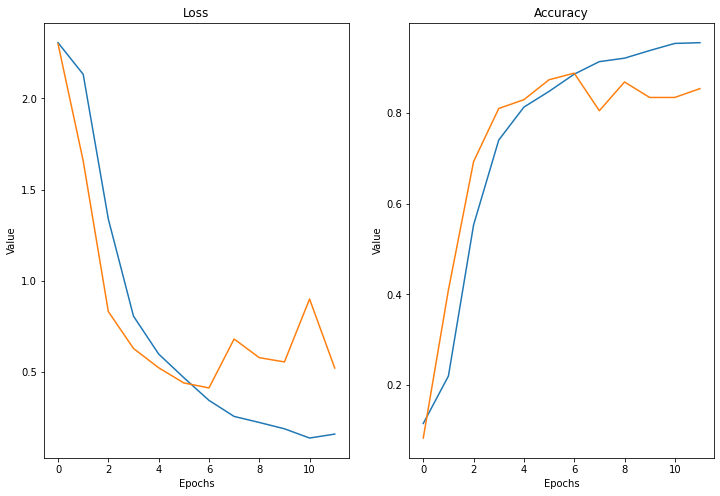

***************Trainig_my_model_9*****************
Epoch 1/200
1843/1843 [==============================] - 8s 4ms/step - loss: 2.3055 - accuracy: 0.1080 - val_loss: 2.3091 - val_accuracy: 0.0927
Epoch 2/200
1843/1843 [==============================] - 7s 4ms/step - loss: 2.1861 - accuracy: 0.1915 - val_loss: 1.7944 - val_accuracy: 0.3707
Epoch 3/200
1843/1843 [==============================] - 7s 4ms/step - loss: 1.4502 - accuracy: 0.4943 - val_loss: 0.8822 - val_accuracy: 0.6878
Epoch 4/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.8609 - accuracy: 0.7065 - val_loss: 0.6775 - val_accuracy: 0.7902
Epoch 5/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.5985 - accuracy: 0.8112 - val_loss: 0.5945 - val_accuracy: 0.8341
Epoch 6/200
1843/1843 [==============================] - 7s 4ms/step - loss: 0.4903 - accuracy: 0.8356 - val_loss: 0.4595 - val_accuracy: 0.8488
Epoch 7/200
1843/1843 [==============================] - 8s 4ms/step - loss: 0.

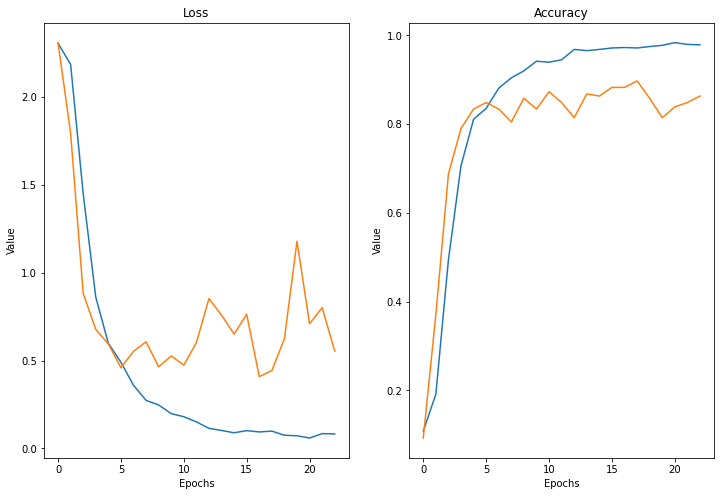

In [17]:
epochs = 200
batch_size = 1
validation_split = 0.2

for i in range(len(model_list)):
    print("***************Trainig_my_model_{}*****************".format(i))
    epoch, hist = train_model_v1(model_list[i], features, labels, epochs, batch_size) 

    # Plot a graph of the metric vs. epochs.
    list_of_metrics_to_plot = ['loss','val_loss','accuracy','val_accuracy']
    plot_curve(epoch, hist, list_of_metrics_to_plot)

In [18]:
result_list = []

for i in range(len(model_list)):
    print("************************Evaluating_my_model_{}************************".format(i))
    result = model_list[i].evaluate(X_val, y_val)
    result_list.append(result)

************************Evaluating_my_model_0************************
13/13 [==============================] - 0s 8ms/step - loss: 0.2234 - accuracy: 0.9244
************************Evaluating_my_model_1************************
13/13 [==============================] - 0s 4ms/step - loss: 0.1079 - accuracy: 0.9780
************************Evaluating_my_model_2************************
13/13 [==============================] - 0s 4ms/step - loss: 0.1584 - accuracy: 0.9390
************************Evaluating_my_model_3************************
13/13 [==============================] - 0s 4ms/step - loss: 0.0616 - accuracy: 0.9732
************************Evaluating_my_model_4************************
13/13 [==============================] - 0s 5ms/step - loss: 0.0409 - accuracy: 0.9878
************************Evaluating_my_model_5************************
13/13 [==============================] - 0s 4ms/step - loss: 0.0362 - accuracy: 0.9927
************************Evaluating_my_model_6*************

In [19]:
pred_list = []

for i in range(len(model_list)):
    print("************************Predicting_my_model_{}************************".format(i))
    pred = model_list[i].predict(X_test)
    pred_list.append(pred)

************************Predicting_my_model_0************************
************************Predicting_my_model_1************************
************************Predicting_my_model_2************************
************************Predicting_my_model_3************************
************************Predicting_my_model_4************************
************************Predicting_my_model_5************************
************************Predicting_my_model_6************************
************************Predicting_my_model_7************************
************************Predicting_my_model_8************************
************************Predicting_my_model_9************************


In [20]:
pred_df = pd.DataFrame(test["id"])
final_pred = np.array([0] * 204800).reshape(20480, 10)

for i in range(len(model_list)):
    pred_df['pred{}'.format(i)] = np.argmax(pred_list[i], axis = 1)
    final_pred = final_pred + pred_list[i]

pred_df['final_pred'] = np.argmax(final_pred, axis = 1)

In [21]:
pred_df

,id,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,final_pred
0,2049,6,6,6,6,6,6,6,6,6,6,6
1,2050,9,9,9,9,9,9,9,9,8,9,9
2,2051,8,8,8,8,8,3,8,8,2,8,8
3,2052,0,0,0,0,0,0,0,0,0,0,0
4,2053,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,4,4,4,4,4,4,4,4,4,4,4
20476,22525,1,1,1,1,1,1,1,1,1,1,1
20477,22526,6,6,6,6,6,6,6,6,6,6,6
20478,22527,3,3,3,8,3,3,8,8,3,8,3


In [24]:
submission = pred_df[['id', 'final_pred']].rename(columns = {'final_pred' : 'digit'})
submission.to_csv("baseline.csv", index = False)
submission

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,3


In [26]:
for i in range(len(model_list)):
  tf.keras.models.save_model(model_list[i],'ckpt1/model{}'.format(i))

INFO:tensorflow:Assets written to: ckpt1/model0/assets
INFO:tensorflow:Assets written to: ckpt1/model1/assets
INFO:tensorflow:Assets written to: ckpt1/model2/assets
INFO:tensorflow:Assets written to: ckpt1/model3/assets
INFO:tensorflow:Assets written to: ckpt1/model4/assets
INFO:tensorflow:Assets written to: ckpt1/model5/assets
INFO:tensorflow:Assets written to: ckpt1/model6/assets
INFO:tensorflow:Assets written to: ckpt1/model7/assets
INFO:tensorflow:Assets written to: ckpt1/model8/assets
INFO:tensorflow:Assets written to: ckpt1/model9/assets


In [27]:
re_model_list = []

for i in range(len(model_list)):
    print("************************Loading_my_model_{}************************".format(i))
    my_model = tf.keras.models.load_model('ckpt1/model{}'.format(i))
    my_model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.00001),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    
    print("************************Re-training_my_model_{}************************".format(i))
    my_model.fit(X_val, y_val, epochs = 5, batch_size = 1,validation_split=0.1)
    
    re_model_list.append(my_model)

************************Loading_my_model_0************************
************************Re-training_my_model_0************************
Epoch 1/5
410/410 [==============================] - 2s 4ms/step - loss: 0.2798 - accuracy: 0.9000
Epoch 2/5
410/410 [==============================] - 2s 4ms/step - loss: 0.1703 - accuracy: 0.9390
Epoch 3/5
410/410 [==============================] - 2s 4ms/step - loss: 0.1532 - accuracy: 0.9415
Epoch 4/5
410/410 [==============================] - 2s 4ms/step - loss: 0.1486 - accuracy: 0.9512
Epoch 5/5
410/410 [==============================] - 2s 4ms/step - loss: 0.1325 - accuracy: 0.9537
************************Loading_my_model_1************************
************************Re-training_my_model_1************************
Epoch 1/5
410/410 [==============================] - 2s 4ms/step - loss: 0.1345 - accuracy: 0.9610
Epoch 2/5
410/410 [==============================] - 2s 4ms/step - loss: 0.0912 - accuracy: 0.9707
Epoch 3/5
410/410 [============

In [28]:
re_pred_list = []

for i in range(len(model_list)):
    print("************************Predicting_my_re_model_{}************************".format(i))
    pred = re_model_list[i].predict(X_test)
    re_pred_list.append(pred)

************************Predicting_my_re_model_0************************
************************Predicting_my_re_model_1************************
************************Predicting_my_re_model_2************************
************************Predicting_my_re_model_3************************
************************Predicting_my_re_model_4************************
************************Predicting_my_re_model_5************************
************************Predicting_my_re_model_6************************
************************Predicting_my_re_model_7************************
************************Predicting_my_re_model_8************************
************************Predicting_my_re_model_9************************


In [29]:
re_pred_df = pd.DataFrame(test["id"])
re_final_pred = np.array([0] * 204800).reshape(20480, 10)

for i in range(len(model_list)):
    re_pred_df['pred{}'.format(i)] = np.argmax(re_pred_list[i], axis = 1)
    re_final_pred = re_final_pred + re_pred_list[i]

re_pred_df['final_pred'] = np.argmax(re_final_pred, axis = 1)

In [30]:
re_pred_df

,id,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,final_pred
0,2049,6,6,6,6,6,6,6,6,6,6,6
1,2050,9,9,9,9,9,9,9,9,9,9,9
2,2051,8,8,8,8,8,8,8,8,8,8,8
3,2052,0,0,0,0,0,0,0,0,0,0,0
4,2053,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,4,4,4,4,4,4,4,4,4,4,4
20476,22525,1,1,1,1,1,1,1,1,1,1,1
20477,22526,6,6,6,6,6,6,6,6,6,6,6
20478,22527,3,3,3,3,3,3,8,3,3,3,3


In [31]:
submission = re_pred_df[['id', 'final_pred']].rename(columns = {'final_pred' : 'digit'})
submission.to_csv("baseline.csv", index = False)
submission

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,3
